In [17]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

# from models import ResNet as resnet_cifar

from models import ResNet as resnet_cifar

import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader
from summaries import TensorboardSummary

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库
import os
from alexnet import AlexNet 

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print('Initialization')
print('Init Finished!')

Initialization
Init Finished!


In [18]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 256
args_depth = 20
num_classes = 10

PATH_baseline = '../paper_exp/baseline/test_256bs_200epoch_layer3_baseline'
PATH_icnn = '../Resnet_ICNN_Struct/paper_exp/baseline/test_256bs_200epoch_layer3_icnn'
# PATH_icnn = '../paper_exp/baseline/test_256bs_150epoch_layer2_icnn'

# PATH_baseline = '../Different_Models/paper_exp/alexnet/test_256bs_200epoch_layer3_baseline'
# PATH_icnn = '../Different_Models/paper_exp/alexnet/test_256bs_200epoch_layer3_icnn'

In [19]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [20]:
def load_model(path):
    model_path = os.path.join(path, 'saved_model.pt')
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
#     model = AlexNet(num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)

    model.load_state_dict(torch.load(model_path))
#     model = torch.load(model_path)
    print('Successfully Load Model: ', os.path.basename(model_path))
    return model

In [21]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [22]:
def get_weights(model):
    conv_layers_weights = dict()
    cnt = 0
    for name, param in model.named_parameters():
        print(name,param.shape)
        conv_layers_weights[name] = param
#         if 'weight' in name and 'conv' in name and param.requires_grad == True and 'fc' not in name:
#             conv_layers_weights[name] = param
#             print(name,param.shape)
        cnt += 1

    filter_specified = conv_layers_weights['module.features.10.weight']
    return filter_specified 

In [23]:
device = torch.device("cuda")
def ortho(conv_layer):
    c_out, c_in, k_w, k_h = conv_layer.shape
    conv_layer = conv_layer.view(c_out, -1)
    c_out = conv_layer.shape[0]
    normalized_conv_layer = conv_layer / torch.sqrt(torch.sum(torch.pow(conv_layer, 2), dim=1)).unsqueeze(1).expand(
        conv_layer.shape)
    P = torch.abs(
        torch.matmul(normalized_conv_layer, normalized_conv_layer.transpose(0, 1)) - torch.eye(c_out).to(device))
    assert (P.shape == (c_out, c_out))
#     rank = torch.sum(P, dim=1) / c_out
    return P.cpu().detach().numpy()

In [24]:
base_model = load_model(PATH_baseline)
icnn_model = load_model(PATH_icnn)

weights_base_model = get_weights(base_model)
print(weights_base_model.shape)
weights_icnn_model = get_weights(icnn_model)
print(weights_icnn_model.shape)

base_correlation_scores = ortho(weights_base_model)
icnn_correlation_scores = ortho(weights_icnn_model)


/home/zengyuyuan/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'alexnet.AlexNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Successfully Load Model:  saved_model.pt
Successfully Load Model:  saved_model.pt
module.features.0.weight torch.Size([64, 3, 3, 3])
module.features.0.bias torch.Size([64])
module.features.3.weight torch.Size([192, 64, 3, 3])
module.features.3.bias torch.Size([192])
module.features.6.weight torch.Size([384, 192, 3, 3])
module.features.6.bias torch.Size([384])
module.features.8.weight torch.Size([256, 384, 3, 3])
module.features.8.bias torch.Size([256])
module.features.10.weight torch.Size([256, 256, 3, 3])
module.features.10.bias torch.Size([256])
module.fc_layers.1.weight torch.Size([2048, 4096])
module.fc_layers.1.bias torch.Size([2048])
module.fc_layers.4.weight torch.Size([2048, 2048])
module.fc_layers.4.bias torch.Size([2048])
module.fc_layers.6.weight torch.Size([10, 2048])
module.fc_layers.6.bias torch.Size([10])
torch.Size([256, 256, 3, 3])
module.features.0.weight torch.Size([64, 3, 3, 3])
module.features.0.bias torch.Size([64])
module.features.3.weight torch.Size([192, 64, 3,

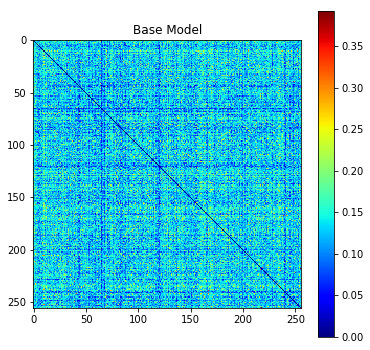

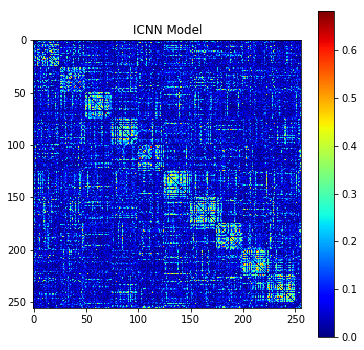

In [25]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(base_correlation_scores,cmap=plt.cm.jet)
plt.colorbar(im,orientation='vertical')
plt.title('Base Model')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(icnn_correlation_scores,cmap=plt.cm.jet)
plt.colorbar(im,orientation='vertical')
plt.title('ICNN Model')
plt.show()